# **Set-up of the project**

In [ ]:
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sn
!pip install text_hammer
import text_hammer as th
import string
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
import nltk
from nltk.corpus import stopwords
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Activation, LSTM ,Bidirectional, Flatten, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn import metrics

# **Import data**

In [ ]:
# retrieve the dataset from github
url1 = 'https://raw.githubusercontent.com/baiyuankok/Sentiment-Analysis/master/train.csv'
url2 = 'https://raw.githubusercontent.com/baiyuankok/Sentiment-Analysis/master/test.csv'
url3 = 'https://raw.githubusercontent.com/baiyuankok/Sentiment-Analysis/master/validation.csv'

# news headlines are referred as "Input", categories are referred as "Sentiment"
df_train = pd.read_csv(url1, names=['Input', 'Sentiment'])
df_test = pd.read_csv(url2, names=['Input', 'Sentiment'])
df_val = pd.read_csv(url3, names=['Input', 'Sentiment'])

# **Data preparation**

### Data cleaning

In [ ]:
nltk.download('stopwords')
tqdm_notebook.pandas()
stop_words_list = stopwords.words("english")
white_list = ["not", "no"] # store the desired stopwords

punctuation_table  = str.maketrans("","", string.punctuation)
del punctuation_table[ord("%")] #deleting % from punctuation table
del punctuation_table[ord(".")] #deleting . from punctuation table
del punctuation_table[ord("-")] #deleting - from punctuation table

def text_preprocessing(df,col_name):
    df[col_name] = df[col_name].apply(lambda x: str(x).lower())
    df[col_name] = df[col_name].apply(lambda x: th.cont_exp(x)) # usage example: you're -> you are; i'm -> i am
    df[col_name] = df[col_name].apply(lambda x: th.remove_emails(x))
    df[col_name] = df[col_name].apply(lambda x: th.remove_html_tags(x))
    df[col_name] = df[col_name].apply(lambda x: th.remove_urls(x))
    df[col_name] = df[col_name].apply(lambda x: th.remove_accented_chars(x))
    df[col_name] = df[col_name].apply(lambda x: str(x).translate(punctuation_table))
    df[col_name] = df[col_name].apply(lambda x: ' '.join([word for word in x.split(' ') if (word not in stop_words_list or word in white_list)]))
    
    return(df)

In [ ]:
df__train_cleaned = text_preprocessing(df_train,'Input')

### Tokenization

In [ ]:
tokenizer = Tokenizer(filters=punctuation_table, lower=True)
tokenizer.fit_on_texts(df__train_cleaned['Input']) # create vocabulary with training texts

In [ ]:
max_length = 50
X_train = tokenizer.texts_to_sequences(df__train_cleaned['Input']) # create lists (sequences) that are collection of integers representing words
X_train_pad = pad_sequences(X_train, maxlen = max_length, padding = 'post') # pad sequences to the same length
X_test = tokenizer.texts_to_sequences(df_test.Input)
X_test_pad = pad_sequences(X_test, maxlen = max_length, padding = 'post')
X_val = tokenizer.texts_to_sequences(df_val.Input)
X_val_pad = pad_sequences(X_val, maxlen = max_length, padding = 'post')

### Convert target categories to numbers
*   "-1" is converted into [ 1.  0.  0.]
*   "0" is converted into [ 0.  1.  0.]
*   "1" is converted into [ 0.  0.  1.]

In [ ]:
sentiment_converter = {-1:0, 0:1, 1:2} # convert the sentiment -1 to 0, 0 to 1, 1 to 2
number_of_sentiment_category = 3

def convert_dataframe_to_numpy(dataframe):
  return dataframe['Sentiment'].replace(sentiment_converter).to_numpy()

def convert_category(dataframe):
  new_numpy = convert_dataframe_to_numpy(dataframe)
  return to_categorical(new_numpy, num_classes=number_of_sentiment_category)

In [ ]:
y_train = convert_category(df_train)
y_test = convert_category(df_test)
y_val = convert_category(df_val)

# Word embedding

### Create embedding matrix from pretrained GloVe file

In [ ]:
embedding_index = dict()
with open('/content/drive/MyDrive/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
      values=line.split()
      word=values[0]
      vector = np.asarray(values[1:], 'float32')
      embedding_index[word] = vector

### Maps each word index to its corresponding embedding vector

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
vector_dimension = 100
embedding_matrix = np.zeros((vocab_size ,vector_dimension))
for word, i in tokenizer.word_index.items():
  embedding_vector = embedding_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

### Convert words in dataset to word embedding

In [ ]:
def convert_words_to_word_embedding(dataset):
  rows_number = dataset.shape[0]
  columns_number = dataset.shape[1]
  new_array = np.zeros((rows_number, columns_number, vector_dimension)) # Create a new array filled with zeros.
  for index, value in np.ndenumerate(dataset):
    new_array[index] = embedding_matrix[value] # assign the value for each index in the array

  return new_array

In [ ]:
embedded_X_train = convert_words_to_word_embedding(X_train_pad)
embedded_X_test = convert_words_to_word_embedding(X_test_pad)
embedded_X_val = convert_words_to_word_embedding(X_val_pad)

# Create and train model

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(max_length, vector_dimension)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=number_of_sentiment_category))
model.add(Activation('softmax'))
defined_optimizer = tensorflow.keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss = 'categorical_crossentropy', optimizer = defined_optimizer, metrics = 'accuracy') # the type of loss is chosen because it is multi-class, single-label prediction

print(model.summary())

In [ ]:
# save the best model with highest validation accuracy after trained with all epochs
model_checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

history = model.fit(embedded_X_train, y_train, 
                    epochs=200, 
                    batch_size=500, 
                    validation_data=(embedded_X_val,y_val), 
                    verbose=1, 
                    callbacks = [model_checkpoint])

# Model evaluation

In [ ]:
best_model = load_model('/content/drive/MyDrive/model.h5')

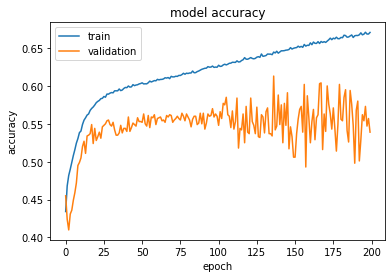

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

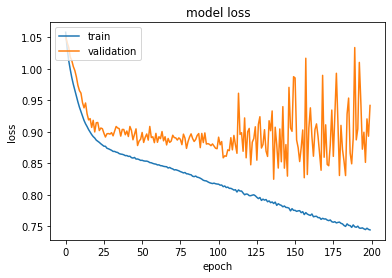

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Prediction on test dataset

In [ ]:
y_pred =  np.argmax(best_model.predict(embedded_X_test), axis  =  1)
y_true = np.argmax(y_test, axis = 1)

print(metrics.classification_report(y_pred, y_true))

              precision    recall  f1-score   support

           0       0.47      0.68      0.56       179
           1       0.42      0.57      0.48       226
           2       0.81      0.60      0.69       595

    accuracy                           0.60      1000
   macro avg       0.57      0.61      0.58      1000
weighted avg       0.66      0.60      0.62      1000



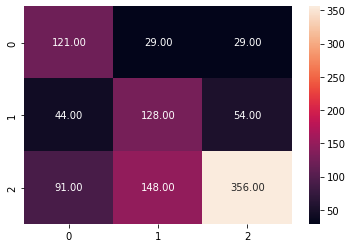

In [ ]:
cm = metrics.confusion_matrix(y_pred, y_true)
sn.heatmap(cm, annot=True, fmt = '.2f')